In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split, Dataset
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import os
import time
from torch.quantization import quantize_dynamic
import copy
import numpy as np

In [2]:
np.random.seed(42)

In [3]:
train_df= pd.read_csv("https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/train.tsv",sep="\t", header=None)
test_df = pd.read_csv("https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/test.tsv",sep="\t", header=None)

In [4]:
print("Shape of train dataset:", train_df.shape)
print("Shape of test dataset", test_df.shape)

Shape of train dataset: (6920, 2)
Shape of test dataset (1821, 2)


In [5]:
train_df.columns = ['sentence', 'label']
test_df.columns = ['sentence', 'label']

In [6]:
train_df.head(3)

,sentence,label
0,"a stirring , funny and finally transporting re...",1
1,apparently reassembled from the cutting room f...,0
2,they presume their audience wo n't sit still f...,0


In [7]:
test_df.head(3)

,sentence,label
0,"no movement , no yuks , not much of anything",0
1,"a gob of drivel so sickly sweet , even the eag...",0
2,"gangs of new york is an unapologetic mess , wh...",0


In [8]:
vectorizer = TfidfVectorizer(max_features=10000)
X = vectorizer.fit_transform(train_df['sentence']).toarray()
y = train_df['label'].values

X_test = vectorizer.transform(test_df['sentence']).toarray()
y_test = test_df['label'].values

In [9]:
X.shape

(6920, 10000)

In [10]:
X_test.shape

(1821, 10000)

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

In [12]:
import torch.nn as nn
input_dim = X.shape[1]
class MLP(nn.Module):
    def __init__(self, input_size=input_dim, hidden_sizes=[512, 256, 128, 64], output_size=2):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)

        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)

        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.3)

        self.fc4 = nn.Linear(hidden_sizes[2], hidden_sizes[3])
        self.relu4 = nn.ReLU()
        self.dropout4 = nn.Dropout(0.3)

        self.fc5 = nn.Linear(hidden_sizes[3], output_size)

    def forward(self, x):
        x = self.dropout1(self.relu1(self.fc1(x)))
        x = self.dropout2(self.relu2(self.fc2(x)))
        x = self.dropout3(self.relu3(self.fc3(x)))
        x = self.dropout4(self.relu4(self.fc4(x)))
        x = self.fc5(x)
        return x

model = MLP(input_size = input_dim)

In [13]:
model

MLP(
  (fc1): Linear(in_features=10000, out_features=512, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (relu3): ReLU()
  (dropout3): Dropout(p=0.3, inplace=False)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (relu4): ReLU()
  (dropout4): Dropout(p=0.3, inplace=False)
  (fc5): Linear(in_features=64, out_features=2, bias=True)
)

In [14]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total Trainable Parameters are :" , total_params)

Total Trainable Parameters are : 5293122


In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [16]:
import matplotlib.pyplot as plt

num_epochs = 10
best_val_acc = 0.0

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * X_batch.size(0)
        _, predicted = torch.max(outputs, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

    avg_train_loss = train_loss / total
    train_acc = correct / total
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            val_loss += loss.item() * X_batch.size(0)
            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    avg_val_loss = val_loss / total
    val_acc = correct / total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss={avg_train_loss:.4f}, Train Acc={train_acc:.4f}, "
          f"Val Loss={avg_val_loss:.4f}, Val Acc={val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "checkpoint.pt")


Epoch 1/10: Train Loss=0.6213, Train Acc=0.6340, Val Loss=0.4330, Val Acc=0.7999
Epoch 2/10: Train Loss=0.2731, Train Acc=0.8893, Val Loss=0.4341, Val Acc=0.8100
Epoch 3/10: Train Loss=0.0932, Train Acc=0.9671, Val Loss=0.6063, Val Acc=0.7883
Epoch 4/10: Train Loss=0.0226, Train Acc=0.9931, Val Loss=1.1061, Val Acc=0.7926
Epoch 5/10: Train Loss=0.0076, Train Acc=0.9977, Val Loss=1.4231, Val Acc=0.7731
Epoch 6/10: Train Loss=0.0041, Train Acc=0.9986, Val Loss=1.6005, Val Acc=0.7832
Epoch 7/10: Train Loss=0.0011, Train Acc=0.9996, Val Loss=1.8744, Val Acc=0.7832
Epoch 8/10: Train Loss=0.0012, Train Acc=0.9996, Val Loss=1.9299, Val Acc=0.7948
Epoch 9/10: Train Loss=0.0025, Train Acc=0.9991, Val Loss=1.9321, Val Acc=0.7840
Epoch 10/10: Train Loss=0.0060, Train Acc=0.9982, Val Loss=1.3409, Val Acc=0.7912


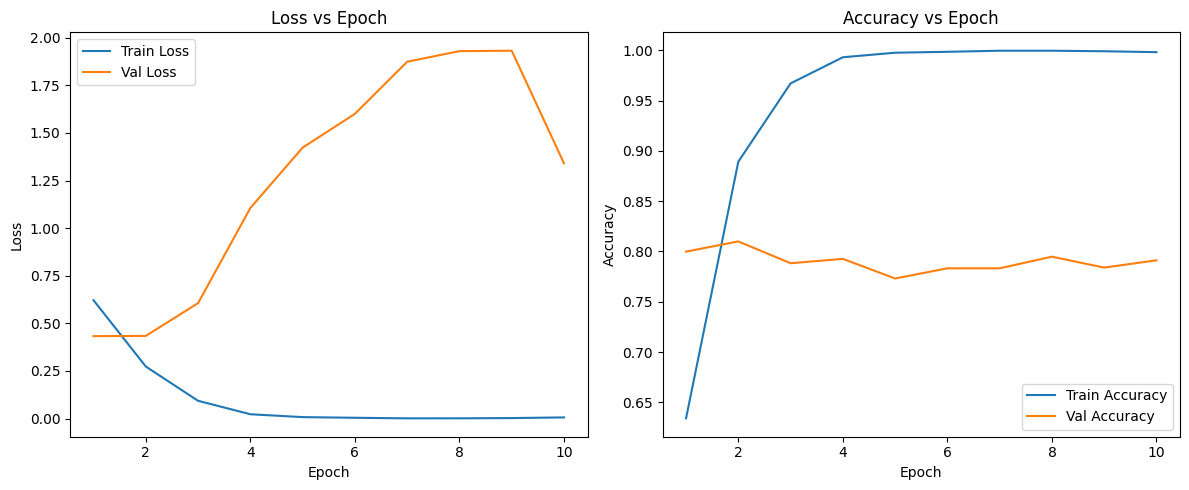

In [17]:
epochs = np.arange(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()

plt.tight_layout()
plt.show()


In [18]:
best_model = MLP(input_size=X.shape[1])
best_model.load_state_dict(torch.load("checkpoint.pt"))
best_model.to(device)
best_model.eval()

MLP(
  (fc1): Linear(in_features=10000, out_features=512, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (relu3): ReLU()
  (dropout3): Dropout(p=0.3, inplace=False)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (relu4): ReLU()
  (dropout4): Dropout(p=0.3, inplace=False)
  (fc5): Linear(in_features=64, out_features=2, bias=True)
)

In [19]:
correct = 0
total = 0
test_loss = 0.0
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = best_model(X_batch)
        loss = criterion(outputs, y_batch)

        test_loss += loss.item() * X_batch.size(0)
        _, predicted = torch.max(outputs, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

avg_test_loss = test_loss / total
test_acc = correct / total

print(f"Test Loss: {avg_test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


Test Loss: 0.4589
Test Accuracy: 0.8040


In [20]:
def evaluate_model(model, data_loader, criterion, device, model_type="float"):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    inference_time = 0.0

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            if model_type == "dynamic_quantized":
                 X_batch, y_batch = X_batch.to("cpu"), y_batch.to("cpu")
            else:
                 X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            if model_type == "half":
                X_batch = X_batch.half()

            start_time = time.time()
            outputs = model(X_batch)
            if model_type == "half":
                outputs = outputs.float()
            end_time = time.time()
            inference_time += (end_time - start_time)

            loss = criterion(outputs, y_batch)
            total_loss += loss.item() * X_batch.size(0)
            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    avg_loss = total_loss / total
    accuracy = correct / total
    avg_inference_time_ms = (inference_time / total) * 1000
    return avg_loss, accuracy, avg_inference_time_ms

In [21]:
def get_model_size(model=None, path=None, use_state_dict=True):
    if path:
        size_bytes = os.path.getsize(path)
    elif model:
        temp_path = "temp_model_size.pt"
        if use_state_dict:
            torch.save(model.state_dict(), temp_path)
        else:
            torch.save(model, temp_path)
        size_bytes = os.path.getsize(temp_path)
        os.remove(temp_path)
    else:
        return 0
    return size_bytes / (1024 * 1024)


In [22]:
# Original Model
original_loss, original_acc, original_time = evaluate_model(best_model, test_loader, criterion, device, model_type="float")
original_size = get_model_size(path="checkpoint.pt")
print(f"Accuracy: {original_acc*100:.2f}%")
print(f"Storage: {original_size:.4f} MB")
print(f"Avg Inference Time: {original_time:.4f} ms/sample")

Accuracy: 80.40%
Storage: 20.1955 MB
Avg Inference Time: 0.0055 ms/sample


In [23]:
# Dynamic Quantization (INT8)
quantized_model = copy.deepcopy(best_model).to("cpu")
quantized_model.eval()
quantized_model_dynamic = quantize_dynamic(
    quantized_model, {nn.Linear}, dtype=torch.qint8
)
quantized_loss, quantized_acc, quantized_time = evaluate_model(
    quantized_model_dynamic, test_loader, criterion, "cpu", model_type="dynamic_quantized"
)
quantized_size = get_model_size(model=quantized_model_dynamic, use_state_dict=False)
print(f"Accuracy: {quantized_acc*100:.2f}%")
print(f"Storage: {quantized_size:.4f} MB")
print(f"Avg Inference Time: {quantized_time:.4f} ms/sample")

Accuracy: 80.23%
Storage: 5.0589 MB
Avg Inference Time: 0.0784 ms/sample


In [24]:
# Half Precision
half_model = copy.deepcopy(best_model).to(device)
half_model = half_model.half()
half_model.eval()
half_loss, half_acc, half_time = evaluate_model(
    half_model, test_loader, criterion, device, model_type="half"
)
half_size = get_model_size(model=half_model, use_state_dict=True)
print(f"Accuracy: {half_acc*100:.2f}%")
print(f"Storage: {half_size:.4f} MB")
print(f"Avg Inference Time: {half_time:.4f} ms/sample")

Accuracy: 80.34%
Storage: 10.0997 MB
Avg Inference Time: 0.0427 ms/sample


In [25]:
results = {
    "S.I.": [1, 2, 3],
    "Model Name": ["Original", "Dynamic", "Half"],
    "Accuracy (Out of 100)": [f"{original_acc*100:.2f}", f"{quantized_acc*100:.2f}", f"{half_acc*100:.2f}"],
    "Storage (In MB)": [f"{original_size:.4f}", f"{quantized_size:.4f}", f"{half_size:.4f}"],
    "Inference time (In ms/sample)": [f"{original_time:.4f}", f"{quantized_time:.4f}", f"{half_time:.4f}"]
}

results_df = pd.DataFrame(results)

In [26]:
results_df

,S.I.,Model Name,Accuracy (Out of 100),Storage (In MB),Inference time (In ms/sample)
0,1,Original,80.40,20.1955,0.0055
1,2,Dynamic,80.23,5.0589,0.0784
2,3,Half,80.34,10.0997,0.0427
